# LFP power center of mass
### Compute center of mass in power in theta band throughout the trial

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy import ndimage
from scipy import stats 

import mne
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper
import pickle

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

In [2]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

In [368]:
freqs = np.logspace(*np.log10([5,20]), num=31) # define frequencies of interest (log-spaced)
n_cycles = 6 #freqs / 2.  # different number of cycle per frequency
output = 'power'

filter_data_low_freq  = 2
filter_data_high_freq = 208

In [391]:
trial_begin = 0
trial_end   = 1500


## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]



p_epi_count = []
for sub in range(len(sessions)):

    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']
    idx_trials = trials_markers[sessions[sub]]


    for cc in hpc_electrodes[sub]:


        tmp_lfp = lfp[cc]
        tmp_lfp = mne.filter.notch_filter( np.float64(tmp_lfp), fs, [50,100,150,200], notch_widths=20 )
#         tmp_lfp = mne.filter.filter_data(  np.float64(tmp_lfp) , fs, filter_data_low_freq, filter_data_high_freq)

        power = mne.time_frequency.tfr_array_morlet( [[tmp_lfp]],  fs, freqs=freqs, output=output )
        power = power[0,0]



        ### Moments where power is above 75 percentile
        perc = np.percentile(power, 75, axis=1 )
        perc_mask = (power.T > perc.T).T.astype(int)




        ### Find idexes of P_episodes
        p_epi_idx = []
        for fff in range(len(freqs)):
            N =  int(fs*3/freqs[fff])   ### 3: minimum cycles
            p_epi = np.convolve(perc_mask[fff], np.ones((N,))/N, mode='same')
            p_epi_idx.append( np.where( p_epi>0.99 )[0] )

        p_epi_idx = np.concatenate(p_epi_idx)




        ### P_episodes per trial
        for trial in range(len(idx_trials)):

            sss = idx_trials[trial] + trial_begin
            eee = idx_trials[trial] + trial_end

            count =  np.where(  np.logical_and(  p_epi_idx > sss, p_epi_idx < eee  )  )[0].size


            p_epi_count.append( [sub, tmp_density[trial], tmp_speed[trial], tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]] , count] )
            
            
p_epi_count = np.array(p_epi_count)

p_epi_count = pd.DataFrame(p_epi_count, columns=['sub','density','speed','cuesec','p_epi_count'] )            

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Setting up band-stop filter
Filter length of 3379 sa

In [392]:
p_epi_count_np = p_epi_count.to_numpy()

zs_count = []
for sub in range(8):
    idx = np.where(p_epi_count_np[:,0]==sub)[0]
    zs_count.append( stats.zscore(p_epi_count_np[idx,4]) )
    
p_epi_count['p_epi_count_zscore'] = np.concatenate(zs_count)

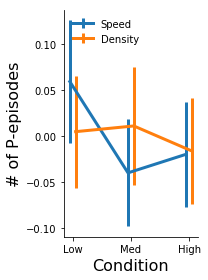

In [393]:
fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)

var_of_interst = 'p_epi_count_zscore'


mmd = p_epi_count.groupby(['density']).mean()[var_of_interst]
mms = p_epi_count.groupby(['speed']).mean()[var_of_interst]

ssd = p_epi_count.groupby(['density']).sem()[var_of_interst]
sss = p_epi_count.groupby(['speed']).sem()[var_of_interst]

plt.errorbar(  np.arange(3)-0.05, mms, yerr=sss, label='Speed', linewidth=3 )
plt.errorbar(  np.arange(3)+0.05, mmd, yerr=ssd, label='Density', linewidth=3  )


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)
plt.legend( frameon=False, loc='upper left')

plt.xlabel('Condition', fontsize=16)
plt.ylabel('# of P-episodes', fontsize=16)

plt.xticks(range(3), ['Low','Med','High'])

plt.tight_layout()
# plt.savefig('../Figures/theta_dominant_freq_both.pdf')

Pearson:  (-0.014617138394555414, 0.677855844121142)
                         sum_sq     df         F    PR(>F)
p_epi_count_zscore     1.982828    1.0  0.172675  0.677856
Residual            9278.282031  808.0       NaN       NaN


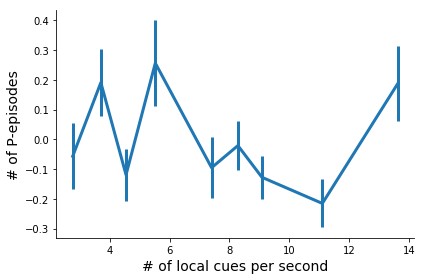

In [394]:
mmcs = p_epi_count.groupby(['cuesec']).mean()[var_of_interst]
sscs = p_epi_count.groupby(['cuesec']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(6)


ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3 )
# sns.violinplot(data=log_wel_all.groupby(['cuesec']),  palette="Set3", bw=1.2, cut=2, linewidth=1 )


fig.patch.set_facecolor('xkcd:white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel('# of P-episodes', fontsize=14)
plt.xlabel('# of local cues per second', fontsize=14)

# plt.ylim(8,12)

plt.tight_layout()



print( 'Pearson: ',  stats.pearsonr(p_epi_count.cuesec, p_epi_count[var_of_interst] ))

cw_lm=ols('cuesec ~ ' + var_of_interst , data=p_epi_count).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')

In [395]:
cw_lm=ols('speed ~ '+ var_of_interst  , data=p_epi_count).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

                        sum_sq     df         F    PR(>F)
p_epi_count_zscore    0.563623    1.0  0.844228  0.358464
Residual            539.436377  808.0       NaN       NaN


In [396]:
cw_lm=ols('density ~ '+ var_of_interst  , data=p_epi_count).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

                        sum_sq     df         F    PR(>F)
p_epi_count_zscore    0.040153    1.0  0.060086  0.806423
Residual            539.959847  808.0       NaN       NaN


In [388]:

lfp = loadmat('../Data/'+sessions[sub]+'.mat')
lfp = lfp['ourData']
idx_trials = trials_markers[sessions[sub]]


cc = hpc_electrodes[sub][0]


tmp_lfp = lfp[cc]
tmp_lfp_n = mne.filter.notch_filter( np.float64(tmp_lfp), fs, [50,100,150,200], notch_widths=20 )

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected


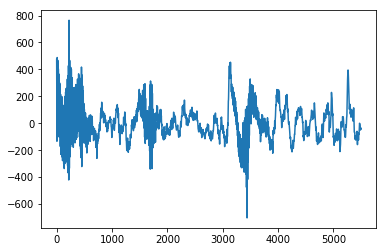

In [389]:
plt.plot(tmp_lfp[500:6000])

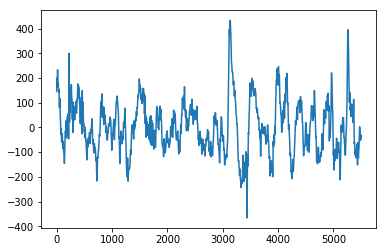

In [390]:
plt.plot(tmp_lfp_n[500:6000])